In [1]:
import pandas as pd
import numpy as np

In [2]:
log_path = 'log.log'

In [3]:
def log_parser(string):
  timestamp, logger_name, log_ctx, msg = string.split(' - ')
  msg_ctx, msg_str = msg.split(':', 1)
  return (
    timestamp, 
    logger_name, 
    log_ctx, 
    msg_ctx.strip(),
    msg_str.strip()
  )

In [4]:
df_log = pd.read_csv(log_path, sep=' - ', names=['timestamp', 'logger', 'ctx', 'msg'])
df_log[['msg_ctx', 'msg']] = df_log['msg'].str.split(':', expand=True, n=1)
df_log['msg'] = df_log['msg'].apply(lambda x: x.strip())
df_log

C:\Users\62896\AppData\Local\Temp\ipykernel_6292\3990417075.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_log = pd.read_csv(log_path, sep=' - ', names=['timestamp', 'logger', 'ctx', 'msg'])


,timestamp,logger,ctx,msg,msg_ctx
0,"2023-07-15 22:14:00,185",BaseServer,INFO,clear_cache,invoked
1,"2023-07-15 22:14:00,185",ClientServer [000],INFO,clear_cache,invoked
2,"2023-07-15 22:14:00,185",ClientServer [001],INFO,clear_cache,invoked
3,"2023-07-15 22:14:00,185",ClientServer [002],INFO,clear_cache,invoked
4,"2023-07-15 22:14:00,185",ClientServer [003],INFO,clear_cache,invoked
...,...,...,...,...,...
1405928,"2023-07-15 22:21:54,810",ClientServer [007],INFO,content_request: ClientServer [007] | movie_id...,invoked
1405929,"2023-07-15 22:21:54,811",ClientServer [007],INFO,cache hit ClientServer [007],event
1405930,"2023-07-15 22:21:54,811",ClientServer [007],INFO,cache_overflow,invoked
1405931,"2023-07-15 22:21:54,811",ClientServer [007],INFO,disk_usage_calc,invoked


In [5]:
df_log_events = df_log

df_log_events = df_log_events[df_log_events['msg_ctx'] == 'event']
df_log_events = df_log_events[df_log_events['msg'].str.startswith('cache')]
df_log_events[['msg', 'msg_trail']] = df_log_events['msg'].str.extract(r'(cache (?:missed|hit))(.*)')


date_parser = lambda x: x

df_log_events

,timestamp,logger,ctx,msg,msg_ctx,msg_trail
12,"2023-07-15 22:14:00,242",ClientServer [002],INFO,cache missed,event,ClientServer [002]
15,"2023-07-15 22:14:00,243",BaseServer,INFO,cache missed,event,ClientServer [002] <- BaseServer
23,"2023-07-15 22:14:00,244",ClientServer [002],INFO,cache missed,event,ClientServer [002]
26,"2023-07-15 22:14:00,245",BaseServer,INFO,cache missed,event,ClientServer [002] <- BaseServer
34,"2023-07-15 22:14:00,245",ClientServer [002],INFO,cache missed,event,ClientServer [002]
...,...,...,...,...,...,...
1405908,"2023-07-15 22:21:54,804",ClientServer [007],INFO,cache missed,event,ClientServer [007]
1405911,"2023-07-15 22:21:54,806",BaseServer,INFO,cache hit,event,ClientServer [007] <- BaseServer
1405919,"2023-07-15 22:21:54,810",ClientServer [007],INFO,cache hit,event,ClientServer [007]
1405924,"2023-07-15 22:21:54,810",ClientServer [007],INFO,cache hit,event,ClientServer [007]


<AxesSubplot:>

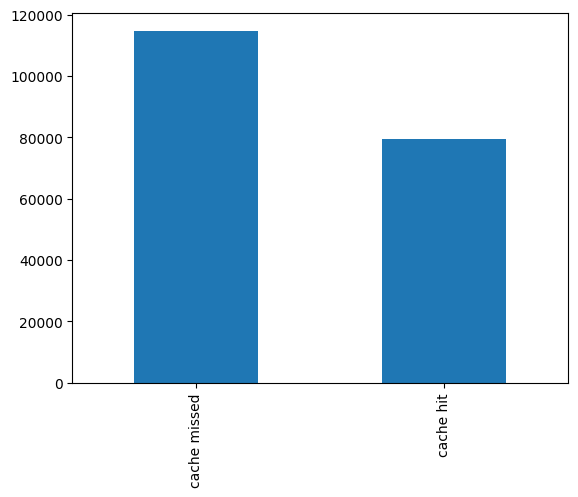

In [6]:
df_log_events['msg'].value_counts(sort=False).plot.bar()

In [7]:
df_log_events['i'] = 1
log_event_gr_sum = df_log_events[['logger', 'msg', 'i']].groupby(['logger', 'msg']).sum()

log_event_gr_sum

i
logger             msg                
BaseServer         cache hit     73972
                   cache missed  20402
ClientServer [000] cache hit       550
                   cache missed  10128
ClientServer [001] cache hit       625
                   cache missed   7266
ClientServer [002] cache hit       593
                   cache missed   9784
ClientServer [003] cache hit       522
                   cache missed  11897
ClientServer [004] cache hit       566
                   cache missed  11586
ClientServer [005] cache hit       596
                   cache missed   9715
ClientServer [006] cache hit       500
                   cache missed   8881
ClientServer [007] cache hit       604
                   cache missed   7426
ClientServer [008] cache hit       554
                   cache missed   8226
ClientServer [009] cache hit       516
                   cache missed   9465

<AxesSubplot:title={'center':'cache hit ratio'}, xlabel='logger'>

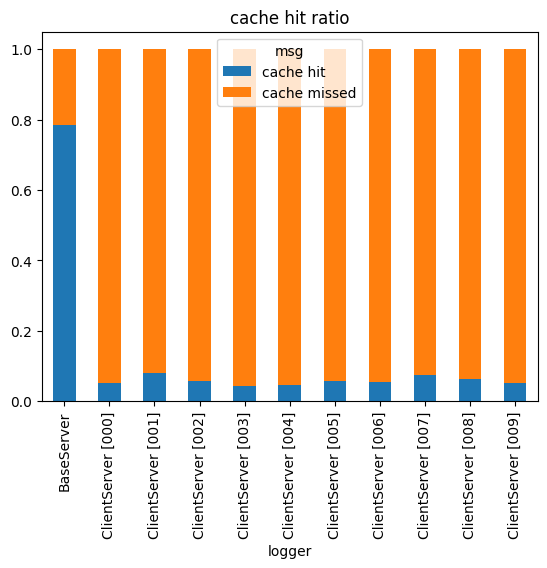

In [8]:
df_piv_log_events = df_log_events.pivot_table(index='logger', columns='msg', values='i', aggfunc='sum')
df_piv_log_events = df_piv_log_events.fillna(0)
df_piv_log_events.divide(df_piv_log_events.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title='cache hit ratio')